# UFO Sightings 

Several questions came to mind when I first reviewed the dataset:
  1. In which states, countries or cities do most UFO sightings occur?
  2. Are UFO sightings increasing or decreasing over time?
  3. What are the most commonly reported shapes of UFOs?
  4. What are common keywords or phrases in UFO descriptions, and do recurring themes emerge?

#### Import Required Libraries and Dataset

In [1]:
import os

# Import data manipulation libraries
import pandas as pd
import numpy as np
import datetime as dt

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from wordcloud import WordCloud

# Utility libraries
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

#### Basic Data Exploration

In [2]:
# Load dataset
df_sightings = pd.read_csv("/kaggle/input/ufo-sightings/scrubbed.csv")

# Preview dataset
print("Dataset Columns:", df_sightings.columns)
print("Dataset Shape:", df_sightings.shape)
df_sightings.info()

Dataset Columns: Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude '],
      dtype='object')
Dataset Shape: (80332, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  

In [3]:
# View first 5 records in dataset
df_sightings.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


#### Data Cleansing


##### Handling Missing Values


In [4]:
# Count missing values before cleaning
print("Missing values before cleaning:")
print(df_sightings.isnull().sum())

# Retain rows with valid state or specific countries
# keeping gb, au, and de as they dont have states and we might want to use them at a later stage
filtered_countries = ['gb', 'au', 'de']
df_filtered = df_sightings[
    (df_sightings['country'].isin(filtered_countries)) |
    (df_sightings['state'].notna())
]

# Drop rows with missing key values
df_filtered = df_filtered.dropna(subset=['country', 'city', 'shape'])

# Count missing values after cleaning
print("Missing values after cleaning:")
print(df_filtered.isnull().sum())

Missing values before cleaning:
datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
dtype: int64
Missing values after cleaning:
datetime                   0
city                       0
state                   2464
country                    0
shape                      0
duration (seconds)         0
duration (hours/min)       0
comments                   8
date posted                0
latitude                   0
longitude                  0
dtype: int64


##### Convert and Extract Features

In [5]:
# Convert datetime to the correct format
df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'], errors='coerce')
print(f"Invalid datetime entries: {df_filtered['datetime'].isnull().sum()}")

# Convert duration to numeric value
df_filtered['duration (seconds)'] = pd.to_numeric(df_filtered['duration (seconds)'], errors='coerce')

# Extract year and month features
df_filtered['year'] = df_filtered['datetime'].dt.year
df_filtered['month'] = df_filtered['datetime'].dt.month

# Drop redundant columns
df_filtered.drop(columns=['duration (hours/min)'], inplace=True)

Invalid datetime entries: 524


In [6]:
print("Cleaned Data Info:")
print(df_filtered.info())
print(df_filtered.head())

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 68988 entries, 0 to 80331
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            68464 non-null  datetime64[ns]
 1   city                68988 non-null  object        
 2   state               66524 non-null  object        
 3   country             68988 non-null  object        
 4   shape               68988 non-null  object        
 5   duration (seconds)  68988 non-null  float64       
 6   comments            68980 non-null  object        
 7   date posted         68988 non-null  object        
 8   latitude            68988 non-null  object        
 9   longitude           68988 non-null  float64       
 10  year                68464 non-null  float64       
 11  month               68464 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 6.8+ MB
None
             date

#### Analysis


##### Sightings per Year

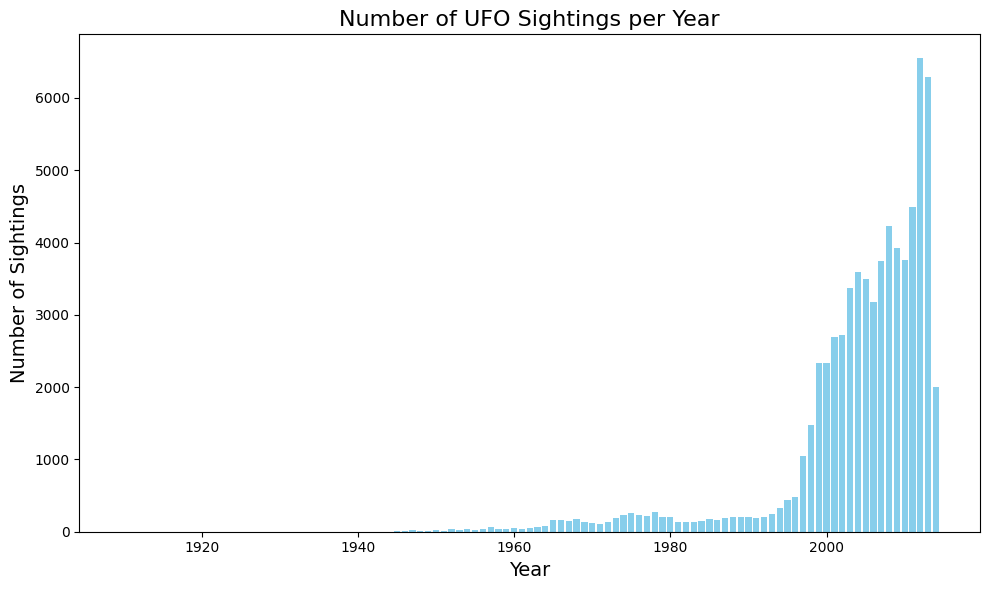

In [7]:
# Group sightings by year
sightings_by_year = df_filtered.groupby('year').size().reset_index(name='sightings')

# Bar plot for yearly trends
plt.figure(figsize=(10, 6))
plt.bar(sightings_by_year['year'], sightings_by_year['sightings'], color='skyblue')

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Sightings', fontsize=14)
plt.title('Number of UFO Sightings per Year', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()


##### Sightings per Month

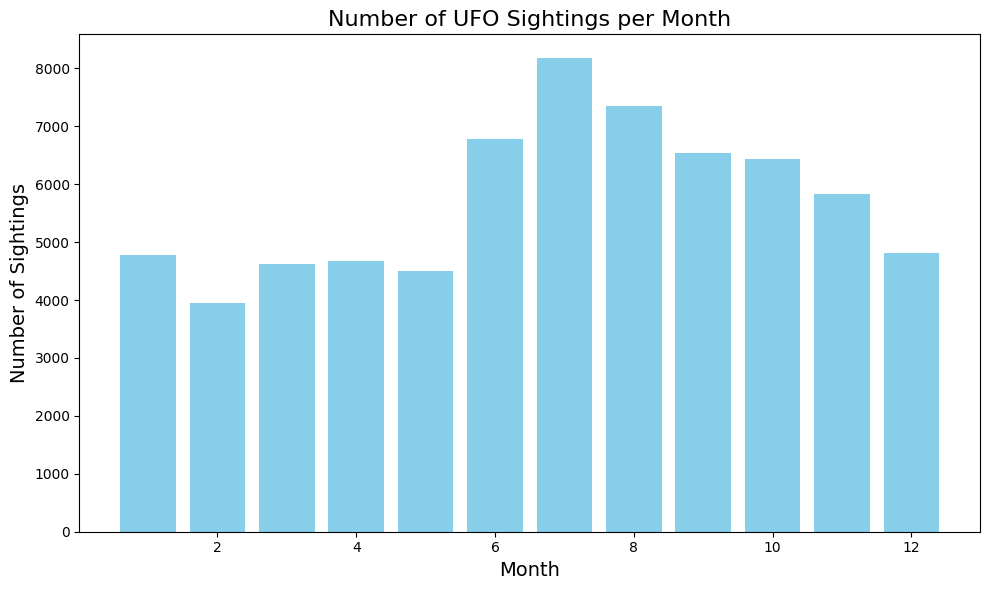

In [8]:
# Group sightings by month
sightings_by_month = df_filtered.groupby('month').size().reset_index(name='sightings')

# Bar plot for monthly trends
plt.figure(figsize=(10, 6))
plt.bar(sightings_by_month['month'], sightings_by_month['sightings'], color='skyblue')

# Add labels and title
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Sightings', fontsize=14)
plt.title('Number of UFO Sightings per Month', fontsize=16)


# Display the plot
plt.tight_layout()
plt.show()

##### Sightings per Hour

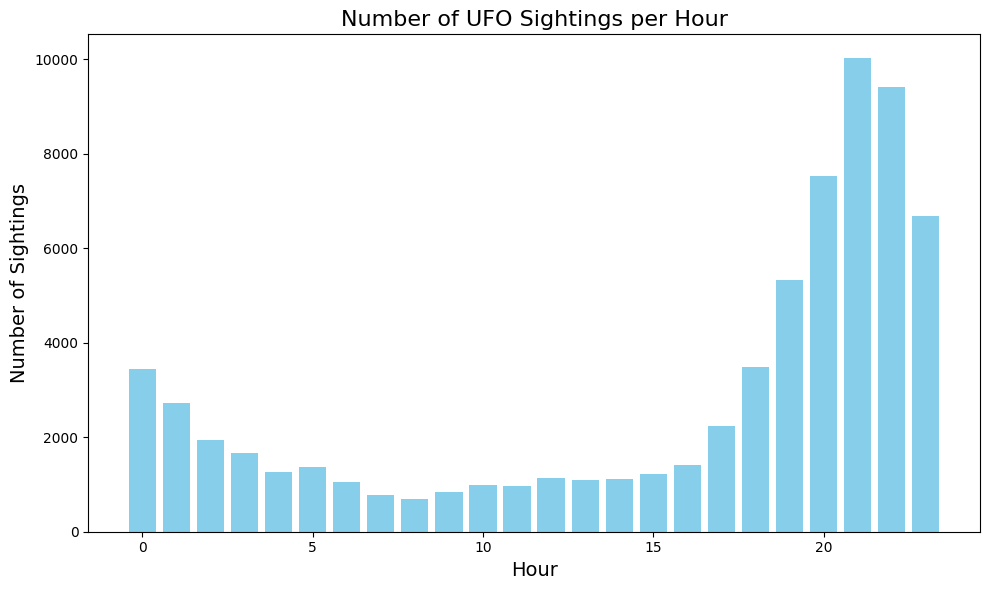

In [9]:
# Sightings by hour
df_filtered['hour'] = df_filtered['datetime'].dt.hour
sightings_by_hour = df_filtered.groupby('hour').size().reset_index(name='sightings')

plt.figure(figsize=(10, 6))
plt.bar(sightings_by_hour['hour'], sightings_by_hour['sightings'], color='skyblue')
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Number of Sightings', fontsize=14)
plt.title('Number of UFO Sightings per Hour', fontsize=16)
plt.tight_layout()
plt.show()

##### Sightings by Country

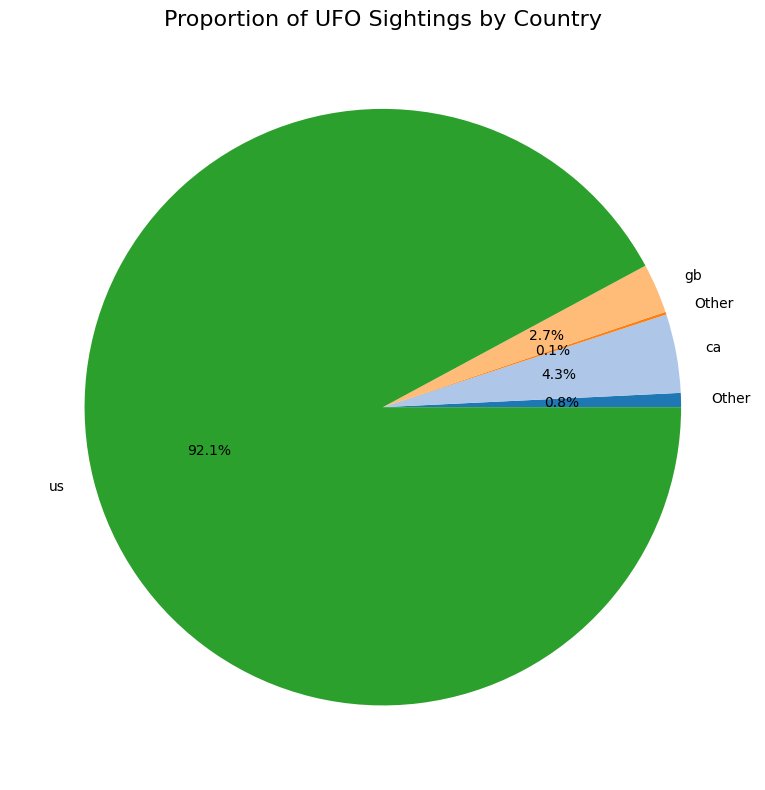

In [10]:
# Group sightings by country
sightings_by_country = df_filtered.groupby('country').size().reset_index(name='sightings')
sightings_by_country['proportion'] = sightings_by_country['sightings'] / sightings_by_country['sightings'].sum()

# Aggregate small proportions into "Other"
threshold = 0.02
sightings_by_country['country'] = np.where(
    sightings_by_country['proportion'] < threshold, 
    'Other',
    sightings_by_country['country']
)

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sightings_by_country['sightings'], 
    labels=sightings_by_country['country'], 
    autopct='%1.1f%%',
    colors=plt.cm.tab20.colors
)
plt.title('Proportion of UFO Sightings by Country', fontsize=16)
plt.tight_layout()
plt.show()

##### Sightings by US State

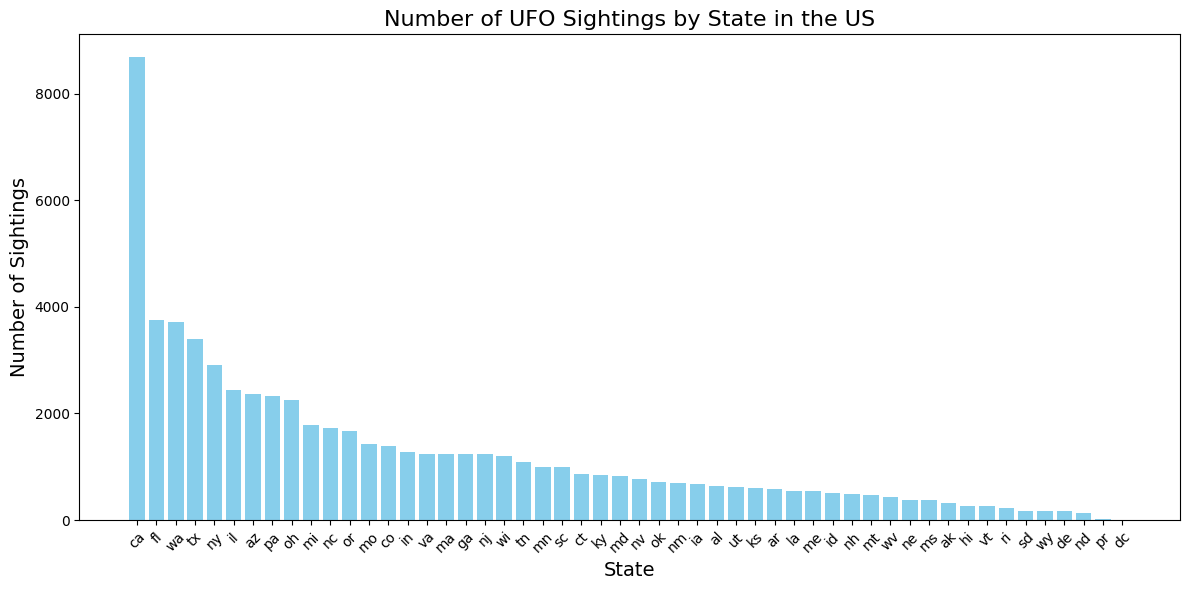

In [11]:
# Filter the data for the United States (US)
df_us = df_filtered[df_filtered['country'] == 'us']

# Group by state and count the number of sightings
sightings_by_state = df_us.groupby('state').size().reset_index(name='sightings')
sightings_by_state = sightings_by_state.sort_values(by='sightings', ascending=False)

# Bar plot for states
plt.figure(figsize=(12, 6))
plt.bar(sightings_by_state['state'], sightings_by_state['sightings'], color='skyblue')
plt.xlabel('State', fontsize=14)
plt.ylabel('Number of Sightings', fontsize=14)
plt.title('Number of UFO Sightings by State in the US', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Sightings by Cities in Great Britain


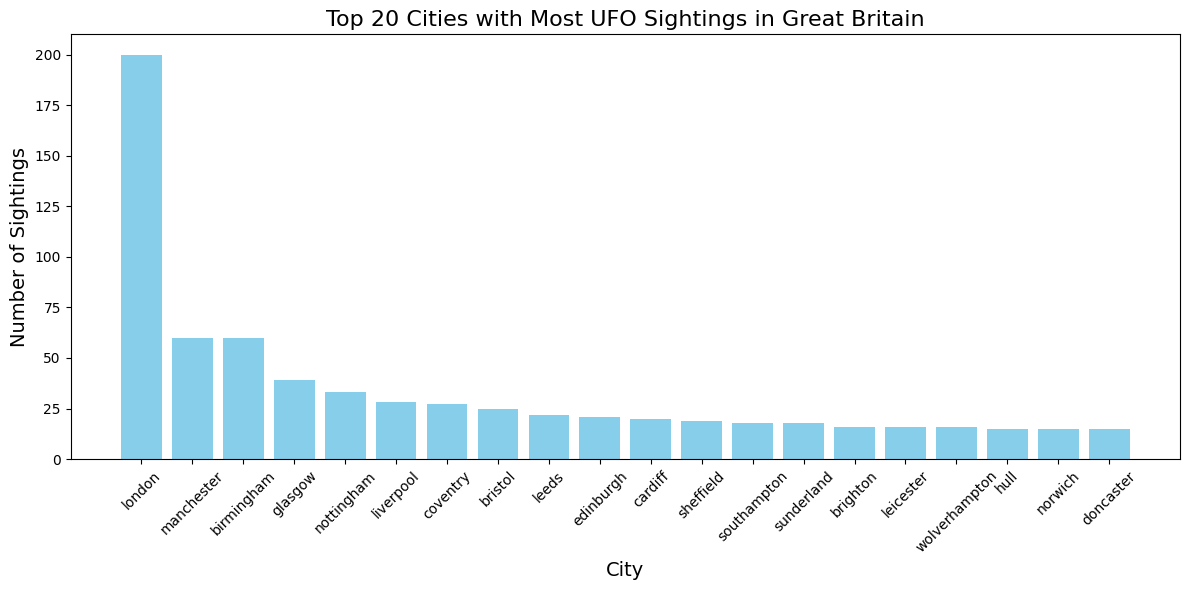

In [12]:
# Filter the data for the United Kingdom (GB)
df_gb = df_filtered[df_filtered['country'] == 'gb']

# Clean the city names by removing the parentheses
df_gb['city_cleaned'] = df_gb['city'].apply(lambda x: re.sub(r'\(.*\)', '', str(x)).strip())

# Count the number of sightings per cleaned city
city_sightings_gb = df_gb['city_cleaned'].value_counts().reset_index()
city_sightings_gb.columns = ['City', 'Sightings']

# Bar plot for top 20 cities
plt.figure(figsize=(12, 6))
plt.bar(city_sightings_gb['City'][:20], city_sightings_gb['Sightings'][:20], color='skyblue')
plt.xlabel('City', fontsize=14)
plt.ylabel('Number of Sightings', fontsize=14)
plt.title('Top 20 Cities with Most UFO Sightings in Great Britain', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Sightings by UFO Shape

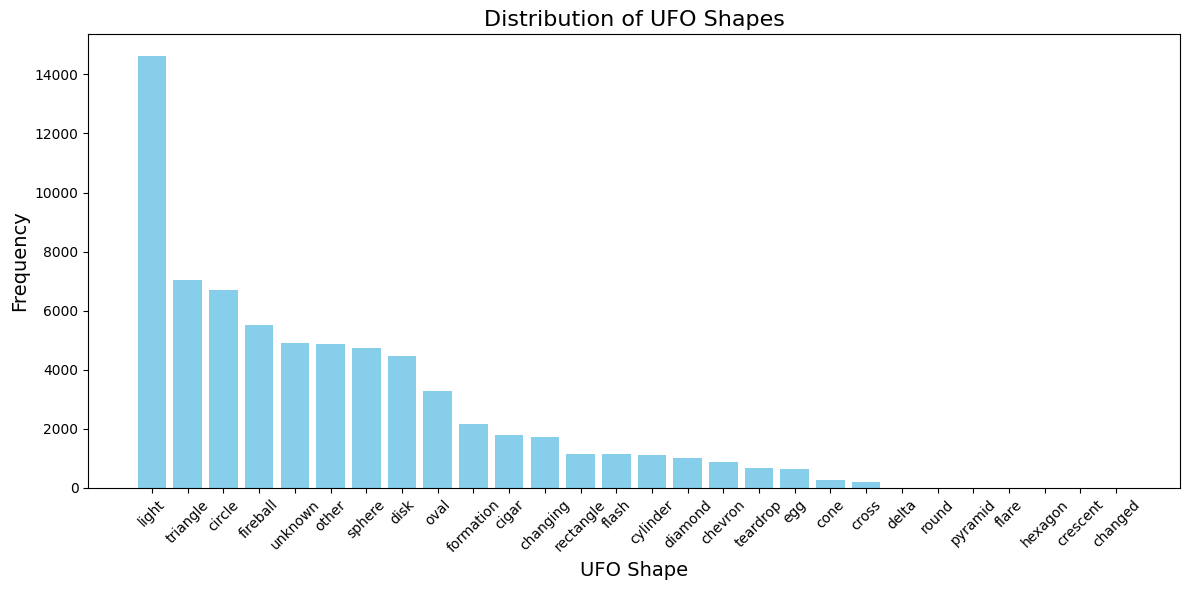

In [13]:
# Distribution of UFO shapes
shape_counts = df_filtered['shape'].value_counts().reset_index()
shape_counts.columns = ['Shape', 'Sightings']

plt.figure(figsize=(12, 6))
plt.bar(shape_counts['Shape'], shape_counts['Sightings'], color='skyblue')
plt.xlabel('UFO Shape', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of UFO Shapes', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

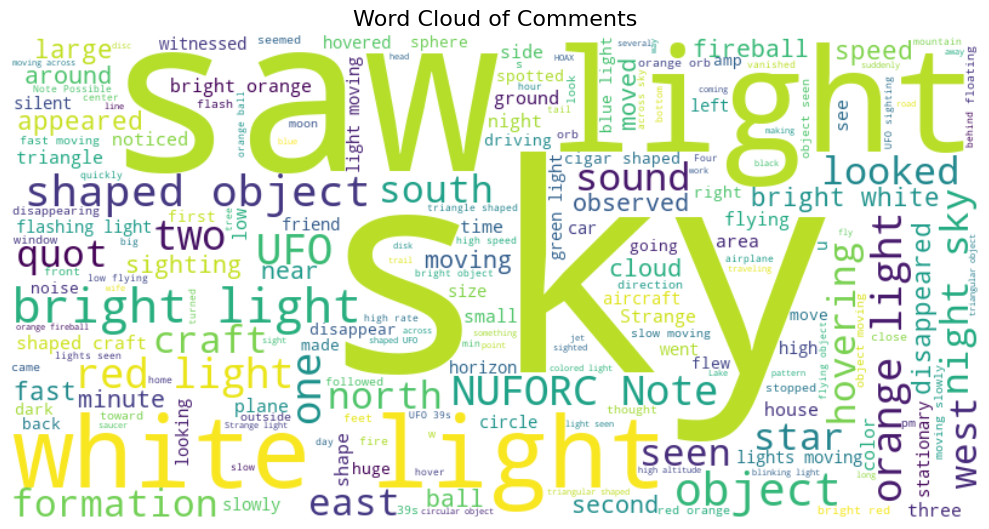

In [14]:
# Generate word cloud from comments
all_comments = " ".join(df_filtered['comments'].dropna())
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate(all_comments)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Comments", fontsize=16)
plt.tight_layout()
plt.show()


#### Findings


Based on the information above we can now answer our initial questions:

  <b>1. In which states, countries or cities do most UFO sightings occur?</b>
    
  - The United States accounts for 92% of all UFO sightings, followed by Canada and Great Britain. 
  - Within the US, California has the highest number of sightings
  - July is the month with the most UFO sightings overall

  <b>2. Are UFO sightings increasing or decreasing over time?</b>

  - UFO sightings appear to be increasing over time, with 3,725 sightings reported in 2010 compared to 6,552 in 2012, representing a 75% increase
    
  <b>3. What are the most commonly reported shapes of UFOs? </b>

  - The most commonly reported shapes are "Light" followed by "Triangle" and "Circle"
  
  <b> 4. What are common keywords or phrases in UFO descriptions, and do recurring themes emerge? </b>

  - The most common phrases/keywords are "Sky" and "Light"